## Warning: This is work and progress and has not been peer reviewed yet
Please be cautious when drawing conclusions from this notebook

## Abstract
Assuming no uncertainty about the liquity (e.g. full information about the network state), we ask how likely it is that payments of various sizes are impossible on the Lightning Network due to misallocation of liquidity in the payment channels between nodes and the observed topology of the network. 

While centrality based measures have been studied frequently in the past to describe the caracteristics of the network we show that this particular problem can be reduced to studying the distribution of feasible max flows / min cuts over the states of the liquidity network.

While computing the distribution of of possible max flows / min cuts is combinatorically exponential in the number of channels and capacity of the network we show that the distribution can easily and quickly be estimated through statistical sampling.

The examined distribution gives us a clear answer to the upper bound for the fraction of successful payments that can be achieved on the network between randomly selected payment pairs, for various amounts and without expensive rebalancing operations. (Those rebalancing operations usually means conducting one or more scarce and expensive blockchain transactions.)

We show on a recent network snapshot with about 16k nodes that the likelihood for two randomly selected nodes to be able to conduct a payment of `100k` sats is just about `37%`. If we however take the subnetwork of roughly `500` professionally maintained nodes (indicated by a positive bos-score) then the chance to be able to conduct a payment successfully for a random payment pair for a `100k` sats payment increases in our experiments to `97.5%`.

In particular we conject that the observed upper bounds subnetwork of profesionall participants will in practice be higher as those nodes actively engage in liquidity management and rebalancing. This violates one of our core assumptions that the states in the liquidity network are randomly distributed which is integral to our considerations and computations. 

## Acknowledegments
This research is funded through [a long term support grant from OpenSats](https://opensats.org/blog/rene-pickhardt-receives-lts-grant) as well as various patreons who are supporting my research. Thanks to Stefan Richter and Christian Decker for helpful discussions and to Rene Treffer for subtelly and indirectly inspiring me to look at this problem while he pointed out that I should stop ignoring the assumption of independent channel states. 

## Introduction
Making a payment on the Lightning Network includes [uncertainty about the remote liquidity](https://arxiv.org/abs/2103.08576) and is thus a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) where a sending node is making several attempts which have only a certain success rate for each attempt. A lot of prior research went into the question how to [plan payment attempts](https://github.com/renepickhardt/Maximum-Expected-Value-Flows-For-Redundant-Overpayments/tree/main) and [select minimum cost flows or candidate paths](https://arxiv.org/abs/2107.05322) in order to [increse the success rate for single attempts](https://arxiv.org/abs/2103.08576). 

However developer and node operators have frequently pointed out that [there is often a certain rate of payments where the software will eventually give up](https://www.youtube.com/watch?v=1f2Z9FgqFH4) - eg because it couldn't deliver the payment within a reasonable time frame (for example one minute). It is reasonable to assume that in such cases while the single attempted onions have a possitive success probability that the actual distribution of liqudity in the payment channels does not allow for a flow with a sufficiently large cut to be found in order to deliver the payment successfully.

## Estimating rate of payments that are impossible to be delivered

This research attempts to address the question of how likely the network is in a state such that a particular payment cannot successfully be delivered no matter how many attempts the sending node has or even if the sending node had full information about the liquidity in all channels. 

## Example instance of the problem
Consider the following network with 5 edges:

```

                (C)
               /   \
              2     2
             /       \
(S)---10---(A)---2---(B)---8---(R)

```

`S` knows it can forward up to `10` units as it has full outbound liquidity and `R` has full inbound liquidity of `8` sats and told this to to `S`. Thus `S` has only uncertainty about the channels `(A,B), (A,C)` and `(C,B)`. 

Assuming for simplicity and only for now a uniform distribution for liquidity in channels we have the following min cost flow solutions to make optimal payment attempts from `S` to `R` for various amounts. 

```
  sats | probability | planned allocation
       |             | (A,B) | (A,C) | (C,B) 
-------+-------------+-------+-------+-------
   1   |     2/3     |   1   |   0   |   0
-------+-------------+-------+-------+--------
   2   |     1/3     |   2   |   0   |   0
-------+-------------+-------+-------+--------
   3   |     4/27    |   2   |   1   |   1
-------+-------------+-------+-------+--------
   4   |     1/27    |   2   |   2   |   2
-------+-------------+-------+-------+--------
   5   |      0      |      not feasable
   
```

Given this table one can already see that the probability that `S` can deliver `2` sats to `R` needs to be at least `1/3` However there are more possible flows. For example `(A,C) = 2` and `(C,B) = 2` has only a `1/9` probability of success but is certainly an attempt `S` could make after the initial attempt to send `2` sats via `(A,B)` was not successul. 

Let us just iterate over all feasable flows on the example network and select the ones for each transport value that maximizes the probability. (This will yield the above table)



In [1]:
a_b = 2
a_c = 2
c_b = 2

total_flow_probabilities = {i:0 for i in range(5)}

#compute and store maximal flow probabilities for each possible payment amount

#iterate over (A,B) channel allocation
for i in range(a_b+1):
    #iterate over (A,C) channel allocation
    for j in range(a_c+1):
        #iterate over (C,B) channel allocation
        for k in range(c_b+1):
            #conservation of flow (yes technically we wouldn't need the look for k)
            if j!=k:
                continue
            # allocation for (A,B) channel in i + (A,C) channel in j 
            total_flow_value = i + j
            #probbility is the product of all channel allocations
            flow_probability = (1-i/(a_b+1)) * (1-j/(a_c+1)) * (1-k/(c_b+1))
            if flow_probability > total_flow_probabilities[total_flow_value]:
                total_flow_probabilities[total_flow_value] = flow_probability

# display flow allocations and successprobabilities for total flow (aka min cost flow if log prob was taken)
for amount_to_send in range(0,5):
    print("Sending {} sats has a success probability of {:4.2f}%".
          format(amount_to_send, total_flow_probabilities[amount_to_send]*100))

Sending 0 sats has a success probability of 100.00%
Sending 1 sats has a success probability of 66.67%
Sending 2 sats has a success probability of 33.33%
Sending 3 sats has a success probability of 14.81%
Sending 4 sats has a success probability of 3.70%


Note that the probability of the most likely flow that we use for payment planning is not giving us the probability that a `2` sats payment is possible. To see this we note that there are several flows that can deliver `2` sats on this triangle shaped graph. We need to count the possible states and feasible flows in order to compute the probability. 

### Computing the likeliehood that `S` can deliver `2` sats to `R`

In order to compute the likelihood that `S` is able to deliver a certain amount of sats we look at the state table of the network. (For simplicity we only consider the edges in one drection: eg `A-->B` but not the reverse edge `B-->A` so if we write that (`A-->B` has a liquidity of `2` ths means that `B-->A` has a liquidity of `0` since the total capacity of the `(A,B)` channel was set to `2` sats in our example

#### Table of possible network states (distributions of liquidity):
```
 A-->B | A-->C | C-->B | min S-R cut
-------+-------+-------+------------
   0   |   0   |   0   |     0
-------+-------+-------+------------
   0   |   0   |   1   |     0
-------+-------+-------+------------
   0   |   0   |   2   |     0
-------+-------+-------+------------
   0   |   1   |   0   |     0
-------+-------+-------+------------
   0   |   2   |   0   |     0
-------+-------+-------+------------
Possible states that allow flow of 1 sat
-------+-------+-------+------------
   0   |   2   |   1   |     1
-------+-------+-------+------------
   0   |   1   |   1   |     1
-------+-------+-------+------------
   0   |   1   |   2   |     1
-------+-------+-------+------------
   1   |   0   |   0   |     1
-------+-------+-------+------------
   1   |   0   |   1   |     1
-------+-------+-------+------------
   1   |   0   |   2   |     1
-------+-------+-------+------------
   1   |   1   |   0   |     1
-------+-------+-------+------------
   1   |   2   |   0   |     1
-------+-------+-------+------------
Possible states that allow flow of 2 sat
-------+-------+-------+------------
   0   |   2   |   2   |     2
-------+-------+-------+------------
   1   |   1   |   1   |     2
-------+-------+-------+------------
   1   |   1   |   2   |     2
-------+-------+-------+------------
   1   |   2   |   1   |     2
-------+-------+-------+------------
   1   |   2   |   2   |     2
-------+-------+-------+------------
   2   |   0   |   0   |     2
-------+-------+-------+------------
   2   |   0   |   1   |     2
-------+-------+-------+------------
   2   |   0   |   2   |     2
-------+-------+-------+------------
   2   |   1   |   0   |     2
-------+-------+-------+------------
   2   |   2   |   0   |     2
-------+-------+-------+------------
Possible states that allow flow of 3 sat
-------+-------+-------+------------
   2   |   1   |   1   |     3
-------+-------+-------+------------
   2   |   1   |   2   |     3
-------+-------+-------+------------
   2   |   2   |   1   |     3
-------+-------+-------+------------   
Possible states that allow flow of 4 sat
-------+-------+-------+------------
   2   |   2   |   2   |     4
       
```

#### Relative frequency of min `S-R` cuts

From the table we see that the network can be in `27` states this is the product of all channel `capacities + 1`. Since we had `3` channels of capacity `2` each we have `3*3*3 = 27` possible states. We count how often states lead to a min `S-R` cut of various values
```
 min S-R cut | frequency | probability
-------------+-----------+------------
      0      |    5      |   18.5%
-------------+-----------+------------
      1      |    8      |   29.7%
-------------+-----------+------------
      2      |    10     |   37.1%
-------------+-----------+------------
      3      |    3      |   11.1%
-------------+-----------+------------
      4      |    1      |    3.7%
      
```

#### Probability of possible `S-R` payment for various amounts


A payment for a certain amount is possible if the min cut is at least the amount. thus we receive the following table for possible payment amounts from `S` to `R`
```
  pay amount | probability 
-------------+-------------
      1      |    81.15%      
-------------+-------------
      2      |    51.85%    
-------------+-------------
      3      |    14.8%      
-------------+-------------
      4      |    3.7%   
```

### Code for the example

let us just look at the example graph and count the total number of states and probabilities for payments of various sizes to be possible. Of Course this assumes `S` has enogh liquidity to `A` and `C` enough liquidity to `R`

In [2]:
for amount_to_send in range(0,5):
    cnt = 0
    positive = 0
    for i in range(a_b+1):
        for j in range(a_c+1):
            for k in range(c_b+1):
                cnt +=1
                if min(i,j) + k >= amount_to_send:
                    positive+=1

    print("Probability that {} can be sent: {:4.2f}%".format(amount_to_send, positive*100./cnt))


Probability that 0 can be sent: 100.00%
Probability that 1 can be sent: 81.48%
Probability that 2 can be sent: 51.85%
Probability that 3 can be sent: 18.52%
Probability that 4 can be sent: 3.70%


## Interesting observation

while the min cost flow that maximizes the probability to send `2` sats on the example network has a probability of `33.3%` the chance that a `2` sat payment is possible (e.g. on a different flow) is `51.85%` 

Of course this does not tell us how to plan payments but it gives us a boundary of what is possible given a certain network topoology. In particular we know that independently of how we plan the payments and conduct the payment delivery loop we can only expect `S` to be able to pay `2` sats to `R` in this very articical example network in `51.85%` of all network states. For the other states we have to either wait that participants change the state to our favor via payments or we have to touch the chain in order to shift liquidity and change the state.

## Formal definition of the problem

From the example we see already that we can compute the probability of a possible payment by computing a min cut for each of the network states. However the the network states grow exponentially with the number and size of payment channels. 

If we have channels `m` channels with capacities `c_1,...,c_m` then then number of states would be `(c_1+1)...(c_m + 1)` for each of the states we would have to compute a min cut for each pair of nodes. While computing the all pair min cuts can be conuducted with a [Gomory Hu tree](https://en.wikipedia.org/wiki/Gomory%E2%80%93Hu_tree) in O(V+1) max flow computations we still have an exponential growth of potential network states and graphs for which to compute the all pair min cuts. 


## Statistical approximation to the possible upper payment amount probability distribution

Due to combinatorically hard nature of the problem we take the [statistical approach of sampling](https://en.wikipedia.org/wiki/Sampling_(statistics)): 

We randomly generate `n` liquidity states of the network defined by a snapshot of the channel graph. For each liquidity state we randomly pick `2` nodes `S` and `R` and compute the value of the min `S-R` cut. This is obviously very optimistic as it assumes `S` knows all the liquidity in the network. Neverthe less it gives us an upper bound of what `S` could send to `R` given the current state of the network. 

### Model assumptions / Limitations

* we assume all states are equally likely. Of course one could argue that rational nodes on the network try to avoid depleeted channels by conducting liquidity management.
* Similarly we assume liqudity in channels being uniformly distributed (this could easily be exchanged in the model)
* We also assume payment pairs to be uniformly distributed. Again this assumption could be modelled differently



In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import json
import random
from collections import Counter

## Some config values

In [4]:
debug = True
num_trials = 10000
load_from_file = True
full_network_filename = "full_network_mincut_samples.txt"
professional_network_filename = "professional_network_mincut_samples.txt"


## Importing the channel graph

This is just some boiler plate code to create the `channel_graph` dictionary that contains the the capacity of each channel for a channel between two nodes identified by their node ids as keys. This is basically taken and stripped down from: 

https://github.com/renepickhardt/mpp-splitter/blob/master/Minimal%20Linearized%20min%20cost%20flow%20example%20for%20MPP.ipynb


In [5]:
node_ids = set()

#used to store the capacity of channels
channel_graph = {}

#$ lightning-cli listchannels > listchannels20220412.json
f = open("listchannels20220412.json")
channels = json.load(f)["channels"]

# let's first find the max channel capacity and all node_ids 
# so that we can build the look up table and use integer unit costs
max_cap = 0

for c in channels:
    src = c["source"]
    dest = c["destination"]
    node_ids.add(src)
    node_ids.add(dest)
    cap = c["satoshis"]
    #FIXME: ignores the later used virtual combination of channels capacities into one large channel
    if cap>max_cap:
        max_cap = cap

print("Max capacity is: ", max_cap)

channel_graph={n:{} for n in node_ids}
for c in channels:
    src = c["source"]
    dest = c["destination"]
    cap = c["satoshis"]

    # we put channels into channel_graph data structure
    # in case of parallel channels we combine capacity into 1 channel
    # from a probabilistic point of view (which we are interested in) this is correct
    if dest in channel_graph[src]:
        channel_graph[src][dest]+=cap
    else:
        channel_graph[src][dest]=cap

Max capacity is:  1400000000


### Importing a list of alegedly profesionally run lightning network nodes

As we also want to see how the upper bound of possible payment probabilties for various amounts changes in the subnet consisting of expert nodes we download the list of nodes that have a bos-score and build the intersection with the nodes in out data set. (if we used the bos-list and the channel graph from the same date we probablity would not need the intersection) However it was interesting to see that half of the nodes in the current bos-node list was already online in the network in a 2 year old data set

In [6]:
# retrieved via wget https://nodes.lightning.computer/availability/v3/btc.json > bosnodes.json
f = open("bosnodes.json","r")
jsn = json.load(f)
bosnodes = set()
for node in jsn["scores"]:
    bosnodes.add(node["public_key"])
    
bos = bosnodes.intersection(node_ids)
print("Of the original {} bos nodes from today's list there are {} in our datasat".format(len(bosnodes), len(bos)))

Of the original 1026 bos nodes from today's list there are 593 in our datasat


### Compute a sample data point

we compute data samples by randomly initiating the state of the liquidity network and randomly chose 2 data points for which we compute the min cut on the reandomly initiated network. 

In [7]:
def create_professional_network_graph(channel_graph,bos):
    G = nx.DiGraph()
    for src in bos:
        if src in channel_graph:
            for dest, cap in channel_graph[src].items():
                if dest in bos:
                    if src < dest:
                        r = random.randint(0,cap)
                        G.add_edge(src,dest,capacity=r)
                        G.add_edge(dest,src,capacity=cap-r)
    return G

def create_full_network_graph(channel_graph):
    G = nx.DiGraph()
    for src in channel_graph.keys():
        for dest, cap in channel_graph[src].items():
            if src < dest:
                r = random.randint(0,cap)
                G.add_edge(src,dest,capacity=r)
                G.add_edge(dest,src,capacity=cap-r)
    return G

def compute_sample_data_point(channel_graph, bos=None):
    G = nx.DiGraph()
    if bos is not None:
        G = create_professional_network_graph(channel_graph,bos)
    else:
        G = create_full_network_graph(channel_graph)
        
    nodes = [n for n in G.nodes()]
    src, dest = random.sample(nodes,2)
    
    flow_value, flow_dict = nx.maximum_flow(G, src, dest)
    return flow_value

### Create samples for the full network

In [8]:
sampled_min_cuts_full_network = []

if load_from_file:
    f = open(full_network_filename,"r")
    for l in f:
        sampled_min_cuts_full_network.append(int(l))
    if debug: 
        print("loaded {} samples from {}".format(len(sampled_min_cuts_full_network), professional_network_filename))

else:
    f = open(professional_network_filename,"w")
    for i in range(num_trials):
        flow_value = compute_sample_data_point(channel_graph)
        sampled_min_cuts_full_network.append(flow_value)
        f.write("{}\n".format(flow_value))
        if debug:
            print(i,flow_value)
    if debug:
        print(sampled_min_cuts_full_network)

loaded 10000 samples from professional_network_mincut_samples.txt


### Create samples for the professional sub network

In [9]:
sampled_min_cuts_professional_network = []

if load_from_file:
    f = open(professional_network_filename,"r")
    for l in f:
        sampled_min_cuts_professional_network.append(int(l))
    if debug: 
        print("loaded {} samples from {}".
              format(len(sampled_min_cuts_full_network), professional_network_filename))
else: 
    f = open(professional_network_filename,"w")
    for i in range(num_trials):
        flow_value = compute_sample_data_point(channel_graph,bos)
        sampled_min_cuts_professional_network.append(flow_value)
        f.write("{}\n".format(flow_value))
        if debug:
            print(i,flow_value)
    if debug:
        print(sampled_min_cuts_professional_network)

loaded 10000 samples from professional_network_mincut_samples.txt


## Evaluate Samples

in the following we assume that we have a list of `sampled_min_cut_values` and we compute some statistics about them

In [10]:
def evaluate_samples(sampled_min_cut_values):
    c=Counter(sampled_min_cut_values)
    trials = len(sampled_min_cut_values)
    successes = trials
    x_values = []
    y_values = []
    for x,frequency in sorted(c.items()):
        successes -= frequency
        x_values.append(x)
        y_values.append(successes/trials)
    if debug:
        print("computed probability distribution from sampled values")
    return x_values, y_values
x,y = evaluate_samples(sampled_min_cuts_professional_network)

computed probability distribution from sampled values


We check graphically that we have computed enough samples by realizeing that the distribution is converging when increasing the sample size

computed probability distribution from sampled values
computed probability distribution from sampled values
computed probability distribution from sampled values
computed probability distribution from sampled values
computed probability distribution from sampled values


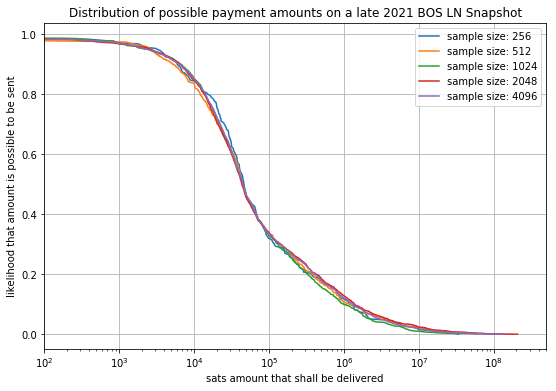

In [11]:
plt.figure(figsize=(9,6))
plt.title("Distribution of possible payment amounts on a late 2021 BOS LN Snapshot".format(len(x)))

for i in range(8,13):
    size = 2**i
    x,y = evaluate_samples(random.sample(sampled_min_cuts_full_network,size))
    plt.plot(x, y,label="sample size: {}".format(size))

plt.xlim(100,500_000_000)
#plt.ylim(0.75,1.0)
plt.xscale("log")
plt.grid()
plt.xlabel("sats amount that shall be delivered")
plt.ylabel("likelihood that amount is possible to be sent")
plt.legend()
plt.show()

### Smaller sample size does not produce a stable distribution yet

we also check the shape of the distribution for smaller sample sizes

computed probability distribution from sampled values
computed probability distribution from sampled values
computed probability distribution from sampled values
computed probability distribution from sampled values
computed probability distribution from sampled values


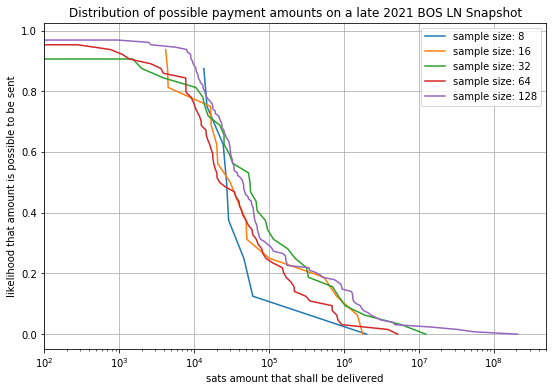

In [12]:
plt.figure(figsize=(9,6))
plt.title("Distribution of possible payment amounts on a late 2021 BOS LN Snapshot".format(len(x)))

for i in range(3,8):
    size = 2**i
    x,y = evaluate_samples(random.sample(sampled_min_cuts_full_network,size))
    plt.plot(x, y,label="sample size: {}".format(size))

plt.xlim(100,500_000_000)
#plt.ylim(0.75,1.0)
plt.xscale("log")
plt.grid()
plt.xlabel("sats amount that shall be delivered")
plt.ylabel("likelihood that amount is possible to be sent")
plt.legend()
plt.show()

## Final result

we plot both distributions for the profesional and full network. In particular we show some percentils and probabilities for some payment amounts

computed probability distribution from sampled values
computed probability distribution from sampled values


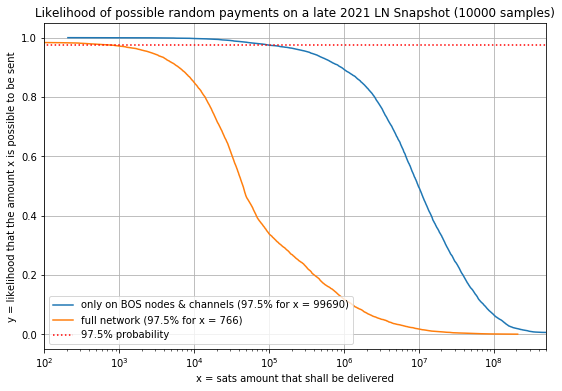

In [13]:
plt.figure(figsize=(9,6))
plt.title("Likelihood of possible random payments on a late 2021 LN Snapshot ({} samples)".format(num_trials))

x_values_full, y_values_full = evaluate_samples(sampled_min_cuts_full_network)
x_values, y_values = evaluate_samples(sampled_min_cuts_professional_network)

for i in range(num_trials):
    if y_values[i]<0.975:
        break

for j in range(num_trials):
    if y_values_full[j]<0.975:
        break

plt.plot(x_values, y_values,label="only on BOS nodes & channels (97.5% for x = {})".format(x_values[i]))
plt.plot(x_values_full, y_values_full,label="full network (97.5% for x = {})".format(x_values_full[j]))
plt.plot([1,x_values[-1]],[y_values[i],y_values[i]],"r:",label="97.5% probability")# for x={}".format(x_values[i]))

plt.xlim(100,500_000_000)
#plt.ylim(0.75,1.0)
plt.xscale("log")
plt.grid()
plt.xlabel("x = sats amount that shall be delivered")
plt.ylabel("y = likelihood that the amount x is possible to be sent")
plt.legend()
plt.savefig("Distribution_of_likelihoods_of_possible_payment_delivery_for_various_amounts.png")
plt.show()

Maximal possible amount to statistically guarantee various Probabilities of possible paymets

In [14]:
print("Maximal sendable amounts to guarantee service level objective `P` in the full network & professional subnet\n\n")
print("  P   |  FULL LN  | Professional subnet")
print("------+-----------+--------------------")

service_level_guarantees = [0.999,0.99,0.975,0.9,0.8,0.5,0.339]
for probability_threshold in service_level_guarantees:
    for i, probability in enumerate(y_values_full):
        if probability < probability_threshold:
            break
    for j, probability in enumerate(y_values):
        if probability < probability_threshold:
            break
    print("{:4.1f}% |{:10} | {:12}".format(probability_threshold*100, x_values_full[i], x_values[j]))
    print("------+-----------+--------------------")
    

Maximal sendable amounts to guarantee service level objective `P` in the full network & professional subnet


  P   |  FULL LN  | Professional subnet
------+-----------+--------------------
99.9% |         0 |         3805
------+-----------+--------------------
99.0% |         0 |        31545
------+-----------+--------------------
97.5% |       766 |        99690
------+-----------+--------------------
90.0% |      6266 |       922529
------+-----------+--------------------
80.0% |     14032 |      2556977
------+-----------+--------------------
50.0% |     44997 |      9806070
------+-----------+--------------------
33.9% |     99946 |     19267389
------+-----------+--------------------


In [15]:
print("Expected Service level `P` in the full network & professional subnet for various target amounts\n\n")
print("  amount |   FULL LN  | Professional subnet")
print("---------+------------+--------------------")

amounts = [1000,10_000,100_000,1_000_000]
for target_amount in amounts:
    for i, amount in enumerate(x_values_full):
        if amount > target_amount:
            break
    for j, amount in enumerate(x_values):
        if amount > target_amount:
            break
    print("{:8} |{:8.2f}%   | {:8.2f}%".format(target_amount, y_values_full[i]*100, y_values[j]*100))
    print("---------+------------+--------------------")


Expected Service level `P` in the full network & professional subnet for various target amounts


  amount |   FULL LN  | Professional subnet
---------+------------+--------------------
    1000 |   97.14%   |    99.96%
---------+------------+--------------------
   10000 |   84.94%   |    99.70%
---------+------------+--------------------
  100000 |   33.87%   |    97.46%
---------+------------+--------------------
 1000000 |   11.78%   |    89.32%
---------+------------+--------------------


## Some statistics about the used datasets

In [16]:
G = create_full_network_graph(channel_graph)
total_cap = 0
for u,v in G.edges():
    cap = G[u][v]["capacity"]
    total_cap += cap

print("\n\n Full Network:")
print("===============================")
print("Number of Nodes: {}".format(len(G.nodes())))
print("Number of Edges: {}".format(len(G.edges())/2))
print("Total Capacity: {} BTC".format(int(total_cap/100_000_000)))
print("Average Liquidity per node: {:4.1f}M sats".format(int(total_cap/len(G.nodes())/1000_000)))
print("Average node degree: {:4.1f}".format(len(G.edges())/2/len(G.nodes())))

G = create_professional_network_graph(channel_graph,bos)
total_cap = 0
for u,v in G.edges():
    cap = G[u][v]["capacity"]
    total_cap += cap

print("\n\n Professional Network:")
print("===============================")
print("Number of Nodes: {}".format(len(G.nodes())))
print("Number of Edges: {}".format(len(G.edges())/2))
print("Total Capacity: {} BTC".format(int(total_cap/100_000_000)))
print("Average Liquidity per node: {:4.1f}M sats".format(int(total_cap/len(G.nodes())/1_000_000)))
print("Average node degree: {:4.1f}".format(len(G.edges())/2/len(G.nodes())))




 Full Network:
Number of Nodes: 16916
Number of Edges: 72635.0
Total Capacity: 3453 BTC
Average Liquidity per node: 20.0M sats
Average node degree:  4.3


 Professional Network:
Number of Nodes: 573
Number of Edges: 7123.0
Total Capacity: 1107 BTC
Average Liquidity per node: 193.0M sats
Average node degree: 12.4


## Discusison, Limitations of the Model and Conclusions 

To the best of our knowledge for the first time we have provided a systematically and statistically reasonable explaination for the fact that Lightnig Network Nodes observe payment failures even while using state of the art routing algorithms that tend to find the liquidity efficiently. 

However our results have to be treated with a grain of salt. Given that payments change the state of the network and that node operators actively engage in liquidity management makes one wonder how reasonable the assumption is that the network states are uniformly random distributed. However at this time relying on this assumption is the best we can do. 

It is nevertheless interesting to see that on the professional network the potentially possible payment amounts are between 2 or 3 orders of magnitude larger (for the same service level objective) than in the full network. At the same time the professional network does only have a tenfold of liqudity provided per node on average. Investigating the impect of provided liquidity, node degree distribution and connectedness is certainly an interesting and important direction for the future.

One could assume that the success rates between profesional participants should become even higher than this upper bound as those nodes actively engage in liquidity management. On the other hand the computed upper bounds assume participants have full knowledge about the network state to be able to effectively compute the min cut. Given the privacy features of the protocol we cannot expect to actually plan a payment in a way that we find the min cut and are able to conduct each payment that may have been possible. 

Yet the liquidity requirements in the network seem quite remarkable . Consider that nodes bring on average `193M` sats to achieve a statistical `97.47%` chance to successfully conduct a `100k`sats payments. This means that almost `2000` times more liquidity is provided per participant than the desired payment amount with the given expected service level. Again such observations have to be taken with caution as we did not yet extract the relvant features to allocate the liquidity in order to maximize the exected service level.

Yet we believe this kind of statistic with the distributions over the min cuts is relevant in explaining the observed lack of reliability and payment failures (not attempt failures) in the network. Node operators should obeviously strive to maximize their expected min cuts with other participants.